In [1]:
import csv
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.

    Example:

     Number of batches = 9

     Batch size = 7                              Remainder = 3
     v     v                                         v v
    |-------|-------|-------|-------|-------|-------|---|
        0       7       14      21      28      35   max batches = 6

    If shuffle is False, the returned batches are the ones started from the indexes:
    0, 7, 14, 21, 28, 35, 0, 7, 14

    If shuffle is True, the returned batches start in:
    7, 28, 14, 35, 14, 0, 21, 28, 7

    To prevent the remainder datapoints from ever being taken into account, each of the shuffled indexes is added a random amount
    8, 28, 16, 38, 14, 0, 22, 28, 9

    This way batches might overlap, but the returned batches are slightly more representative.

    Disclaimer: To keep this function simple, individual datapoints are not shuffled. For a more random result consider using a batch_size of 1.

    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)  # NUmber of data points.
    batch_size = min(data_size, batch_size)  # Limit the possible size of the batch.
    max_batches = int(
        data_size / batch_size
    )  # The maximum amount of non-overlapping batches that can be extracted from the data.
    remainder = (
        data_size - max_batches * batch_size
    )  # Points that would be excluded if no overlap is allowed.

    if shuffle:
        # Generate an array of indexes indicating the start of each batch
        idxs = np.random.randint(max_batches, size=num_batches) * batch_size
        if remainder != 0:
            # Add an random offset to the start of each batch to eventually consider the remainder points
            idxs += np.random.randint(remainder + 1, size=num_batches)
    else:
        # If no shuffle is done, the array of indexes is circular.
        idxs = np.array([i % max_batches for i in range(num_batches)]) * batch_size

    for start in idxs:
        start_index = start  # The first data point of the batch
        end_index = (
            start_index + batch_size
        )  # The first data point of the following batch
        yield y[start_index:end_index], tx[start_index:end_index]

def calculate_loss_neglog(y, tx, w):
    """compute the cost by negative log likelihood.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        a non-negative loss
    """
    assert y.shape[0] == tx.shape[0]
    assert tx.shape[1] == w.shape[0]

    n = np.shape(y)[0]
    y = y.reshape(-1, 1)
    loss = 0
    for i in range(n):
        xi = tx[i]
        yi = y[i]
        fxi = xi.T.dot(w)
        #lossi = yi*np.log(sigmoid(fxi))+(1-yi)*np.log(1-sigmoid(fxi))
        # y is {-1,1}
        lossi = np.log(1 + np.exp(-yi * fxi))
        loss += lossi
    loss /= n

    return float(loss)

def calculate_gradient_logistic(y, tx, w):
    """compute the gradient of loss.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        a vector of shape (D, 1)

    >>> np.set_printoptions(8)
    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> calculate_gradient_logistic(y, tx, w)
    array([[-0.10370763],
           [ 0.2067104 ],
           [ 0.51712843]])
    """
    n = np.shape(y)[0]
    y = y.reshape(-1, 1)
    pred = tx.dot(w) 
    #grad = tx.T.dot(sigmoid(tx.dot(w))-y)/n
    # y is {-1,1}
    grad = -(tx.T.dot(y * sigmoid(-y * pred))) / n
    return grad

def sigmoid(t):
    """apply sigmoid function on t.

    Args:
        t: scalar or numpy array

    Returns:
        scalar or numpy array
    """
    #prevent overflow
    t = np.clip(t, -709, 709)
    sig = 1/(1+np.exp(-t))
    return sig

def reg_logistic_regression(y, tx, lambda_, initial_w, max_iter, gamma):
    """
    Penalized Logistic Regression Algorithm.
    Return the loss and updated w at max_iter-th iteration.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        lambda_: scalar.
        w:  shape=(D, 1)
        gamma: scalar
        lambda_: scalar

    Returns:
        loss: scalar number
        w: shape=(D, 1)
    """
    y = y.reshape(-1, 1)
    n = y.shape[0]
    w = initial_w
    for n_iter in range(max_iter):
        # use SGD
        for y_batch, tx_batch in batch_iter(y, tx, 1, num_batches=len(y)):
            grad = calculate_gradient_logistic(y_batch, tx_batch, w)
            #grad = calculate_gradient_logistic(y, tx, w)
            grad_pen = grad + 2*lambda_*w
            grad_pen[0] = grad[0] 
            w = w - gamma*grad_pen
    l2 = lambda_ * np.sum(w[1:] ** 2)
    loss = float(calculate_loss_neglog(y, tx, w) + l2)
                
    return loss, w

In [3]:
df = pd.read_csv('table.csv')

In [28]:
df

,Unnamed: 0,TTS Model,File,Similarity,Score,eval,pred
0,0,chatterbox,chatterbox/outputs/english/voice_1/text_0.wav,1.000000,3.441406,1,1
1,1,chatterbox,chatterbox/outputs/english/voice_1/text_1.wav,1.000000,3.861328,1,1
2,2,chatterbox,chatterbox/outputs/english/voice_1/text_10.wav,0.998570,3.677734,1,1
3,3,chatterbox,chatterbox/outputs/english/voice_1/text_11.wav,1.000000,4.089844,1,1
4,4,chatterbox,chatterbox/outputs/english/voice_1/text_12.wav,1.000000,3.976562,1,1
...,...,...,...,...,...,...,...
2095,2095,fishspeech,fishspeech/outputs/english/voice_4/s0055.wav,0.976962,3.140625,1,1
2096,2096,fishspeech,fishspeech/outputs/english/voice_4/s0056.wav,0.950298,3.220703,1,1
2097,2097,fishspeech,fishspeech/outputs/english/voice_4/s0057.wav,0.984231,3.316406,1,1
2098,2098,fishspeech,fishspeech/outputs/english/voice_4/s0058.wav,0.992184,3.523438,1,1


In [5]:
df["Score"].mean()

np.float64(3.3683770461309526)

In [6]:
def eval(df, similar_threshs, score_threshs, ratio_sample):
    closest_dist = 1
    closest_similar_thresh = 0
    closest_score_thresh = 0
    best_classifications = None
    for similar_thresh in similar_threshs:
        for score_thresh in score_threshs:
            classifications = []
            for index, row in df.iterrows():
                similarity = row['Similarity']
                score = row['Score']
                if ((similarity >= similar_thresh) and (score >= score_thresh)):
                    classifications.append(1)
                else:
                    classifications.append(-1)
            good = classifications.count(1)
            bad = classifications.count(-1)
            ratio = good/(good+bad)
            dist = abs(ratio_sample - ratio)
            if dist < closest_dist:
                closest_similar_thresh = similar_thresh
                closest_score_thresh = score_thresh
                closest_dist = dist
                best_classifications = classifications
        
        
    return best_classifications, closest_similar_thresh, closest_score_thresh

similar_threshs = [0.94, 0.96, 0.98, 0.99]
score_threshs = [3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8]
human_df = pd.read_csv('human_eval.csv')
sample_good = human_df.human_eval.to_list().count(1)
sample_bad = human_df.human_eval.to_list().count(-1)
sample_ratio = sample_good/(sample_good+sample_bad)

evals, similar_thresh, score_thresh = eval(df, similar_threshs, score_threshs, sample_ratio)

In [7]:
similar_thresh

0.94

In [8]:
score_thresh

3

In [9]:
# change eval to manually chosen one when its manually evaluated
count = 0
for i in range(len(df)):
    for j in range(len(human_df)):
        if (df["File"][i] == human_df["path"][j]):
            evals[i] = human_df["human_eval"][j]
            count = count+1
            continue

In [10]:
df["eval"] = evals

In [11]:
df

,Unnamed: 0,TTS Model,File,Similarity,Score,eval
0,0,chatterbox,chatterbox/outputs/english/voice_1/text_0.wav,1.000000,3.441406,1
1,1,chatterbox,chatterbox/outputs/english/voice_1/text_1.wav,1.000000,3.861328,1
2,2,chatterbox,chatterbox/outputs/english/voice_1/text_10.wav,0.998570,3.677734,1
3,3,chatterbox,chatterbox/outputs/english/voice_1/text_11.wav,1.000000,4.089844,1
4,4,chatterbox,chatterbox/outputs/english/voice_1/text_12.wav,1.000000,3.976562,1
...,...,...,...,...,...,...
2095,2095,fishspeech,fishspeech/outputs/english/voice_4/s0055.wav,0.976962,3.140625,1
2096,2096,fishspeech,fishspeech/outputs/english/voice_4/s0056.wav,0.950298,3.220703,1
2097,2097,fishspeech,fishspeech/outputs/english/voice_4/s0057.wav,0.984231,3.316406,1
2098,2098,fishspeech,fishspeech/outputs/english/voice_4/s0058.wav,0.992184,3.523438,1


In [12]:
df["eval"].to_list().count(1)

1644

In [13]:
x = df[["Similarity", "Score"]].to_numpy()
tx = np.c_[np.ones(len(x)), x]
y = df["eval"].to_numpy()

In [15]:
w0 = np.zeros((tx.shape[1], 1))
loss, w = reg_logistic_regression(y, tx, best_lambda, w0, 300, best_gamma)
pred = np.where((tx @ w).ravel() < 0, -1, 1)

/capstor/scratch/cscs/yfukuhara/tmp/ipykernel_220679/2040448641.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


In [16]:
print(pred.tolist().count(-1))
print(pred.tolist().count(1))

331
1769


In [17]:
loss

0.22592979619273176

In [18]:
pred

array([1, 1, 1, ..., 1, 1, 1], shape=(2100,))

In [19]:
df["pred"] = pred

In [20]:
df

,Unnamed: 0,TTS Model,File,Similarity,Score,eval,pred
0,0,chatterbox,chatterbox/outputs/english/voice_1/text_0.wav,1.000000,3.441406,1,1
1,1,chatterbox,chatterbox/outputs/english/voice_1/text_1.wav,1.000000,3.861328,1,1
2,2,chatterbox,chatterbox/outputs/english/voice_1/text_10.wav,0.998570,3.677734,1,1
3,3,chatterbox,chatterbox/outputs/english/voice_1/text_11.wav,1.000000,4.089844,1,1
4,4,chatterbox,chatterbox/outputs/english/voice_1/text_12.wav,1.000000,3.976562,1,1
...,...,...,...,...,...,...,...
2095,2095,fishspeech,fishspeech/outputs/english/voice_4/s0055.wav,0.976962,3.140625,1,1
2096,2096,fishspeech,fishspeech/outputs/english/voice_4/s0056.wav,0.950298,3.220703,1,1
2097,2097,fishspeech,fishspeech/outputs/english/voice_4/s0057.wav,0.984231,3.316406,1,1
2098,2098,fishspeech,fishspeech/outputs/english/voice_4/s0058.wav,0.992184,3.523438,1,1


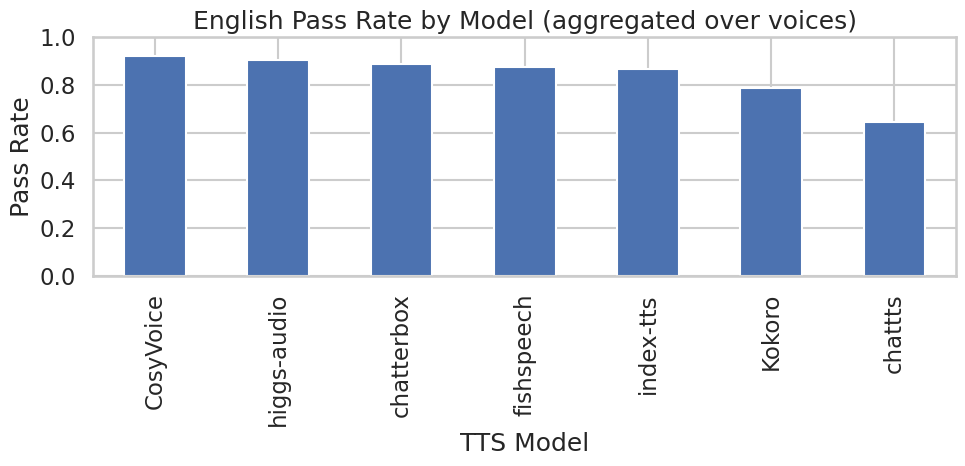

In [39]:
pass_rates = (
    df
    .groupby('TTS Model')['pred']
    .apply(lambda x: (x == 1).mean())
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(10, 5))
pass_rates.plot(kind='bar')
plt.ylabel('Pass Rate')
plt.xlabel('TTS Model')
plt.title('English Pass Rate by Model (aggregated over voices)')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("english_pass_rate_by_model.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
count = 0
for i in range(len(pred)):
    if (df["eval"][i] != pred[i]):
        count+=1
print(count)

185


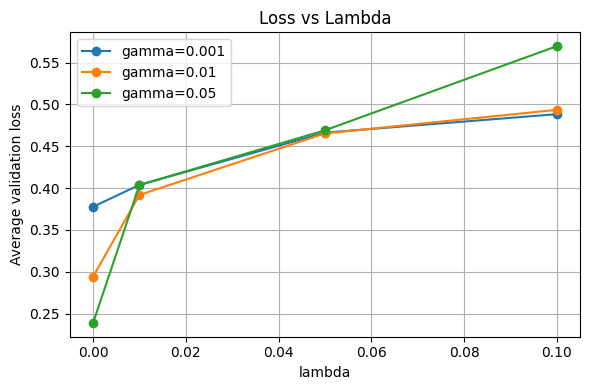

In [22]:
plt.figure(figsize=(6,4))

for gamma in gammas:
    losses = []
    for (lambda_, gamma_, loss) in results:
        if gamma_ == gamma:
            losses.append(loss)
    plt.plot(lambdas, losses, marker="o", label=f"gamma={gamma}")

plt.xlabel("lambda")
plt.ylabel("Average validation loss")
plt.title("Loss vs Lambda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


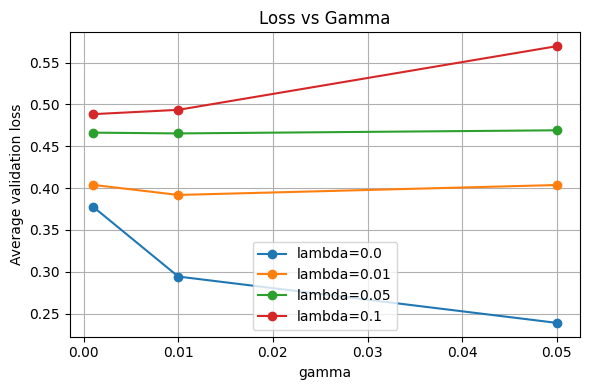

In [23]:
plt.figure(figsize=(6,4))

for lambda_ in lambdas:
    losses = []
    for (lambda__, gamma, loss) in results:
        if lambda_ == lambda__:
            losses.append(loss)
    plt.plot(gammas, losses, marker="o", label=f"lambda={lambda_}")

plt.xlabel("gamma")
plt.ylabel("Average validation loss")
plt.title("Loss vs Gamma")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


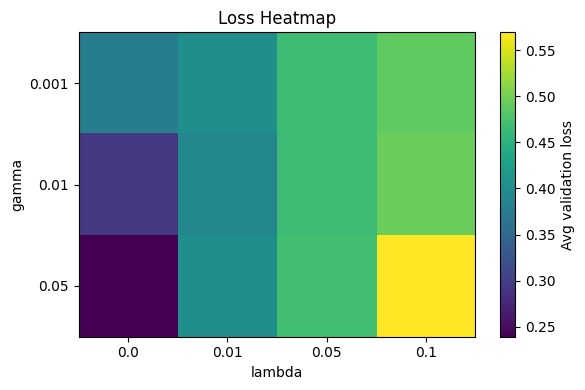

In [24]:
import pandas as pd

df_cv = pd.DataFrame(results, columns=["lambda", "gamma", "loss"])
pivot = df_cv.pivot(index="gamma", columns="lambda", values="loss")

plt.figure(figsize=(6,4))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Avg validation loss")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("lambda")
plt.ylabel("gamma")
plt.title("Loss Heatmap")
plt.tight_layout()
plt.show()

In [25]:
# choose best model
df

,Unnamed: 0,TTS Model,File,Similarity,Score,eval,pred
0,0,chatterbox,chatterbox/outputs/english/voice_1/text_0.wav,1.000000,3.441406,1,1
1,1,chatterbox,chatterbox/outputs/english/voice_1/text_1.wav,1.000000,3.861328,1,1
2,2,chatterbox,chatterbox/outputs/english/voice_1/text_10.wav,0.998570,3.677734,1,1
3,3,chatterbox,chatterbox/outputs/english/voice_1/text_11.wav,1.000000,4.089844,1,1
4,4,chatterbox,chatterbox/outputs/english/voice_1/text_12.wav,1.000000,3.976562,1,1
...,...,...,...,...,...,...,...
2095,2095,fishspeech,fishspeech/outputs/english/voice_4/s0055.wav,0.976962,3.140625,1,1
2096,2096,fishspeech,fishspeech/outputs/english/voice_4/s0056.wav,0.950298,3.220703,1,1
2097,2097,fishspeech,fishspeech/outputs/english/voice_4/s0057.wav,0.984231,3.316406,1,1
2098,2098,fishspeech,fishspeech/outputs/english/voice_4/s0058.wav,0.992184,3.523438,1,1


In [26]:
df_chatter = df[df["TTS Model"] == "chatterbox"]
df_fish = df[df["TTS Model"] == "fishspeech"]
df_index = df[df["TTS Model"] == "index-tts"]
df_chat = df[df["TTS Model"] == "chattts"]
df_cosy = df[df["TTS Model"] == "CosyVoice"]
df_higgs = df[df["TTS Model"] == "higgs-audio"]
df_kokoro = df[df["TTS Model"] == "Kokoro"]
dfs = [df_chatter, df_fish, df_index, df_chat, df_cosy, df_higgs, df_kokoro]

In [27]:
def good_ratio(dfs):
    best_df = None
    best_score = 0
    for df in dfs:
        good = df["pred"].to_list().count(1)
        bad = df["pred"].to_list().count(-1)
        score = good/(good+bad)
        print(score)
        if (score > best_score):
            best_score = score
            best_df = df
    return best_df, best_score

def good_ratio(x):
    pos = (x == 1).sum()
    neg = (x == -1).sum()
    return pos / (neg+pos)

In [28]:
df

,Unnamed: 0,TTS Model,File,Similarity,Score,eval,pred
0,0,chatterbox,chatterbox/outputs/english/voice_1/text_0.wav,1.000000,3.441406,1,1
1,1,chatterbox,chatterbox/outputs/english/voice_1/text_1.wav,1.000000,3.861328,1,1
2,2,chatterbox,chatterbox/outputs/english/voice_1/text_10.wav,0.998570,3.677734,1,1
3,3,chatterbox,chatterbox/outputs/english/voice_1/text_11.wav,1.000000,4.089844,1,1
4,4,chatterbox,chatterbox/outputs/english/voice_1/text_12.wav,1.000000,3.976562,1,1
...,...,...,...,...,...,...,...
2095,2095,fishspeech,fishspeech/outputs/english/voice_4/s0055.wav,0.976962,3.140625,1,1
2096,2096,fishspeech,fishspeech/outputs/english/voice_4/s0056.wav,0.950298,3.220703,1,1
2097,2097,fishspeech,fishspeech/outputs/english/voice_4/s0057.wav,0.984231,3.316406,1,1
2098,2098,fishspeech,fishspeech/outputs/english/voice_4/s0058.wav,0.992184,3.523438,1,1


In [29]:
summary = (
    df
    .groupby("TTS Model")
    .agg(
        avg_similarity=("Similarity", "mean"),
        avg_score=("Score", "mean"),
        good_ratio=("pred", good_ratio),
        count=("pred", "size")
    )
    .sort_values(
    by="good_ratio",
    ascending=False
    ).reset_index()
)

In [30]:
summary

,TTS Model,avg_similarity,avg_score,good_ratio,count
0,CosyVoice,0.974762,3.495065,0.923333,300
1,higgs-audio,0.984660,3.446673,0.906667,300
2,chatterbox,0.988085,3.383464,0.890000,300
3,fishspeech,0.979635,3.405970,0.876667,300
4,index-tts,0.994783,3.283835,0.866667,300
5,Kokoro,0.992087,3.357454,0.786667,300
6,chattts,0.956507,3.206178,0.646667,300
